In [9]:
from reservoirUtils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(<Figure size 1200x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5bd517b70>)

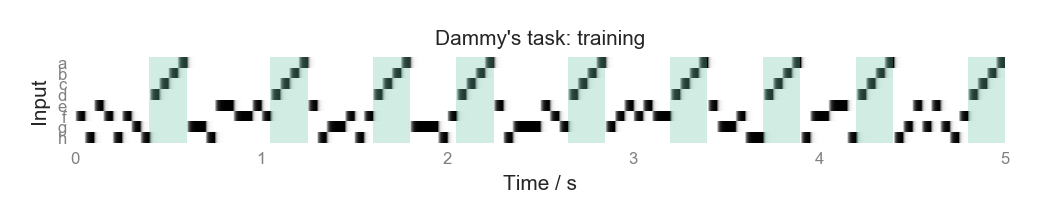

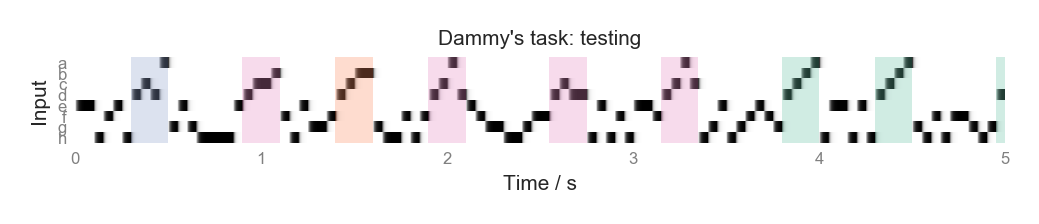

In [58]:
inputParams = defaultInputParams.copy()
inputParams['chunkList'] = [['d','c','b','a']]
inputParams['interChunkSyllables'] = alphabet[4:]
inputParams['gapRange'] = [5,9]
inputs = getInputs(inputParams,totalTime=1000)
plotInputs(inputs,title="Dammy's task: training")

inputParams['chunkList'] = [['d','c','b','a'],['d','c','b','dcb+'],['d','c','dca+','a'],['d','c','dca+','dcb+']]
inputParams['chunkLabels'] = None
inputsTest = getInputs(inputParams,totalTime=100)
plotInputs(inputsTest,title="Dammy's task: testing")

In [35]:
hyperparams = {'Ng' : 300, #no. neurons in each reservoir 
               'n' : 100, #no. reservoir neurons the output neuron is connected to 
               'p' : 0.5, #connection probability amongst recurrent units
               'tau' : 10, #neuron time constant, in ms 
               'dt' : 1, #simulation timestep in ms
               'g_GG' : 1.5, #RNN chaos parameters ( > 1 means chaos)
               'g_Gz' : 1, #feedback strength,
               'alpha' : 200, #learning rate
               'sigma' : 0.3,#amount of network noise
               'Nz' : 1, #no. of output neurons
               'ipr' : 3, #no. of connection to reservoir per input
               'Ni' : inputs['data'].shape[1]}

In [36]:
reservoirPair = ReservoirPair(hyperparams,inputs)
reservoirPair.storeInputs(inputsTest,name='test')

In [43]:
reservoirPair.trainPair()

Training reservoir pair:   0%|          | 0/500000 [00:00<?, ?it/s]

In [44]:
reservoirPair.testPair(testName='testontraining',testData='train',Ntest=1, returnItems=['z','r'])
reservoirPair.testPair(testName='posttraining',testData='test',Ntest=5, returnItems=['z','r'])

Running multiple tests of reservoir:   0%|          | 0/1 [00:00<?, ?it/s]

Test 0:   0%|          | 0/500000 [00:00<?, ?it/s]

Running multiple tests of reservoir:   0%|          | 0/5 [00:00<?, ?it/s]

Test 0:   0%|          | 0/100000 [00:00<?, ?it/s]

Test 1:   0%|          | 0/100000 [00:00<?, ?it/s]

Test 2:   0%|          | 0/100000 [00:00<?, ?it/s]

Test 3:   0%|          | 0/100000 [00:00<?, ?it/s]

Test 4:   0%|          | 0/100000 [00:00<?, ?it/s]

In [26]:
pickleAndSave(reservoirPair,'dammy')

In [27]:
reservoirPair = loadAndDepickle('dammy')

(<Figure size 1200x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd5c1d507f0>)

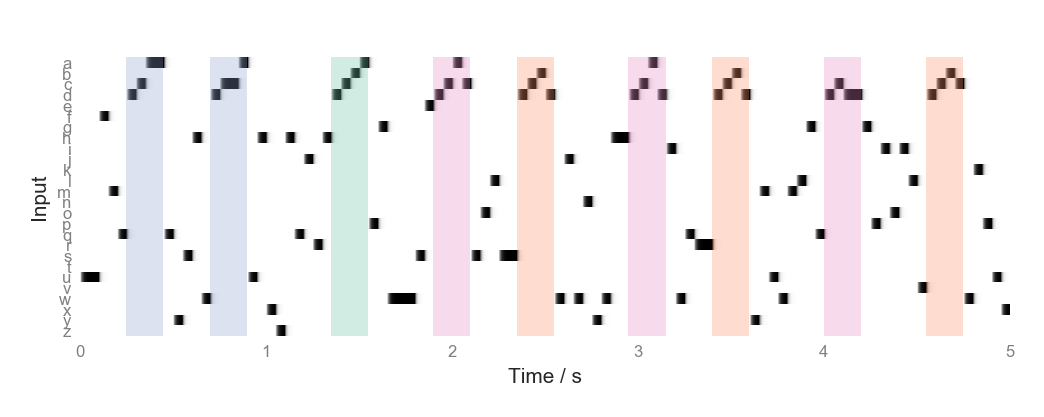

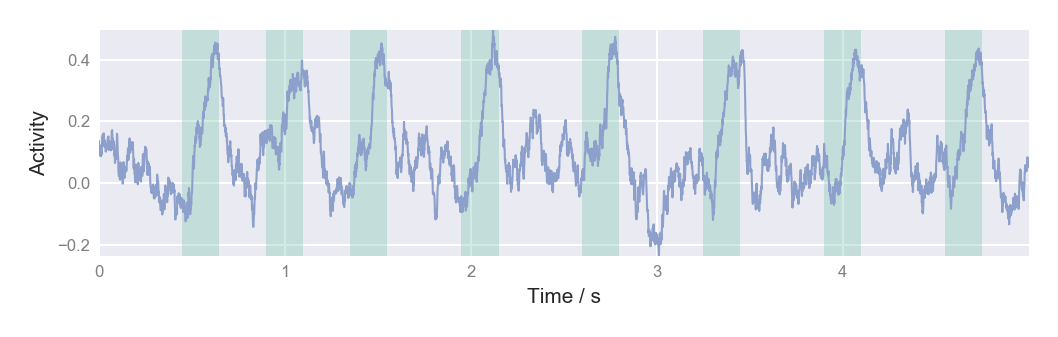

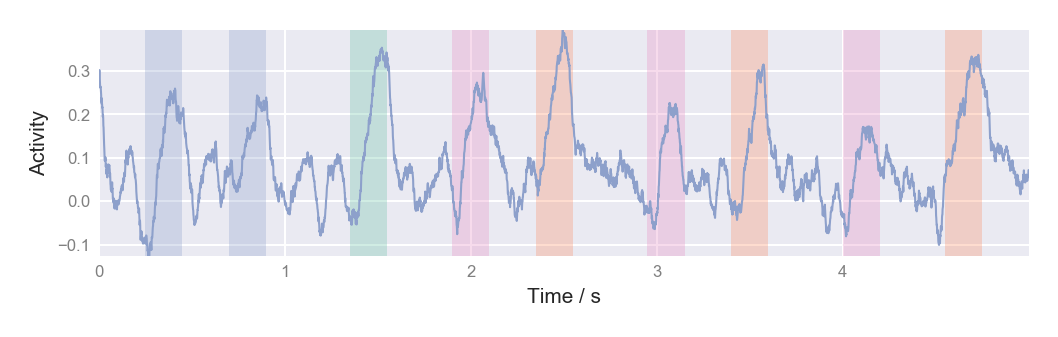

In [59]:
plotInputs(reservoirPair.inputDict['test'],saveName="dammyInput")
plotTest(reservoirPair,testName='testontraining',testData='train',colorOrders=[2],plotTrials=False,saveName="dammyztrain")
plotTest(reservoirPair,testName='posttraining',testData='test',colorOrders=[2],plotTrials=False,saveName="dammyz")

In [50]:
# test low D dynamics of reservoir on chunks 
X = reservoirPair.hist['posttraining']['r'][:,:,0].T
X = X - np.mean(X,axis=0)
XX_T = np.matmul(X.T,X)
eigenvals, eigenvecs = np.linalg.eig(XX_T)

plotX = reservoirPair.hist['posttraining']['r'][:,:,0].T - np.mean(X,axis=0)
reducedX = np.matmul(plotX,eigenvecs[:,:2])

writer = anim.FFMpegWriter(fps=30,bitrate=4000) 
a = AnimatedScatter(reducedX,reservoirPair.inputDict['test'],fps=30,length=5)
a.ani.save('./figures/dammy.mp4', writer=writer,dpi=250)

In [51]:
Video("./figures/dammy.mp4")

Testing chunks: 0it [00:00, ?it/s]

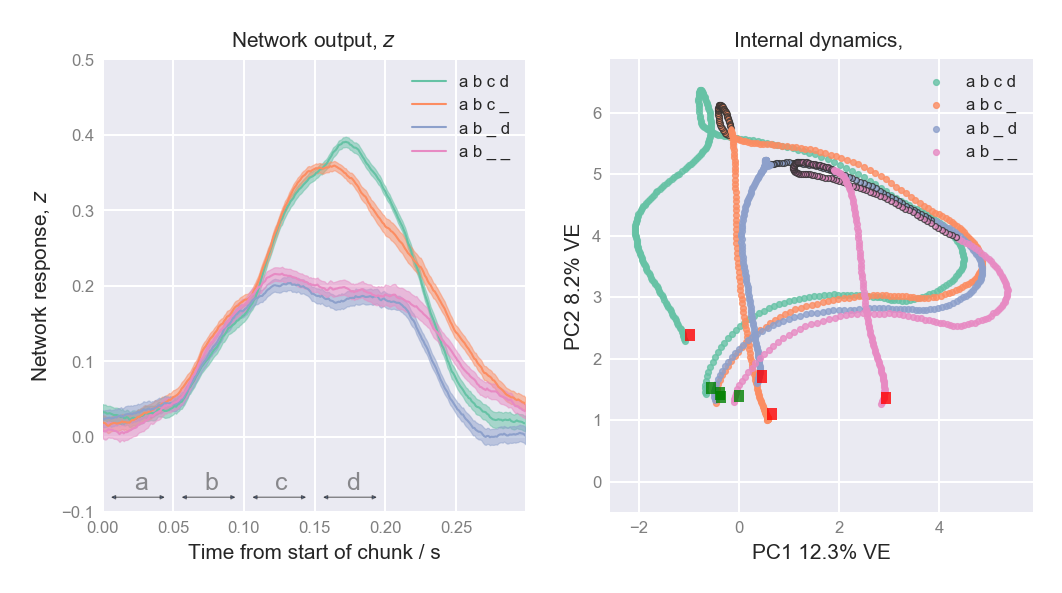

In [55]:
#Make a figure showing how the output and internal dynamics change through chunks
#reservoirPair = loadAndDepickle('dammy')
chunkLabels = ['a b c d','a b c _','a b _ d', 'a b _ _']
testChunks = [['d','c','b','a','abcd_','abcd_'],['d','c','b','dcb+','abcd_','abcd_'],['d','c','dca+','a','abcd_','abcd_'],['d','c','dca+','dcb+','abcd_','abcd_']]

testinputs = reservoirPair.inputDict['test']
traininputs = reservoirPair.inputDict['train']
testdata = reservoirPair.hist['posttraining']
traindata = reservoirPair.hist['testontraining']


#average outputs over chunks
avOutputs = {}
for chunkId in [0,1,2,3]:
    avOutputs[chunkId] = {}
    avOutputs[chunkId]['n'] = 0
    avOutputs[chunkId]['av'] = np.zeros(300)
    avOutputs[chunkId]['var'] = np.zeros(300)
for n_trial in range(testdata['z'].shape[2]):
    for chunk in testinputs['chunkData'][1:-1]:
        chunkId = chunk[0]
        start = np.argmin(np.abs(testinputs['t'] - chunk[1]))
        avOutputs[chunkId]['n'] += 1
        x = testdata['z'][:,start:start+300,n_trial]
        n = avOutputs[chunkId]['n']
        av = avOutputs[chunkId]['av']
        nvar = avOutputs[chunkId]['var']
        newAv = (1 - 1/n)*av + (1/n)*x
        avOutputs[chunkId]['av'] = newAv
        if n >= 2: 
            avOutputs[chunkId]['var'] = nvar + (x-av)*(x-newAv) #Welfords algorithm 
for chunkId in [0,1,2,3]:
    avOutputs[chunkId]['std'] = (avOutputs[chunkId]['var']/(avOutputs[chunkId]['n']-1))**(1/2)

    
#average dim reduced internal dynamics over chunks
nonChunkR = np.zeros(traindata['r'].shape[0]) #start by finding average non-vhunk values to initialise equally at each trial 
n = 0
for i in range(traindata['r'].shape[1]):
    if traininputs['chunkLabelList'][i] == 'r':
        n += 1
        nonChunkR = (1 - 1/n)*nonChunkR + (1/n)*traindata['r'][:,i,0]
nonChunkX = np.arctanh(nonChunkR)
#nonChunkX = np.zeros(300)

avInternal = {}
reservoirPair.res1.sigma = 0.1 #reduce noise for cleaner plots
for (i, chunk) in tqdm(enumerate(testChunks),desc='Testing chunks'):
    avInternal[i] = {}
    avInternal[i]['chunkData'] = np.zeros(shape=(len(chunk)*50,2))
    avInternal[i]['n'] = 0
    for n_trial in range(20):
        inputParams = defaultInputParams.copy()
        inputParams['chunkList'] = [chunk]
        inputParams['singleChunkOnly'] = True
        inputChunk = getInputs(inputParams)
        reservoirPair.storeInputs(inputChunk,name='chunk')
        for _ in range(20):
            avInternal[i]['n'] += 1
            n = avInternal[i]['n']
            reservoirPair.identicalInitialisation(x=nonChunkX) #initial
            reservoirPair.testPair(testName='chunk',testData='chunk',Ntest=1, returnItems=['z','r'],verbose=False)
            X = reservoirPair.hist['chunk']['r'][:,:,0].T
            #X = X - np.mean(X,axis=0)
            reducedX = np.matmul(X,eigenvecs[:,:2])
            avInternal[i]['chunkData'] = (1 - 1/n)*avInternal[i]['chunkData'] + (1/n)*reducedX
        


fig, ax = plt.subplots(1,2,figsize=(4,2))
top, bottom = 0, 0
for chunkId in [0,1,2,3]:
    avOutput = avOutputs[chunkId]['av'][0]
    n = avOutputs[chunkId]['n']
    ci95 = 1.96*avOutputs[chunkId]['std'][0]/np.sqrt(n)
    t = testinputs['t'][:300]
    ax[0].plot(t,avOutput,c='C'+str(chunkId),label=chunkLabels[chunkId])
    ax[0].fill_between(t,avOutput+ci95,avOutput-ci95,color='C'+str(chunkId),alpha=0.5)
    top_, bottom_ = np.round(10*(np.max(avOutput)+0.1))/10, np.round(10*(np.min(avOutput)-0.1))/10
    if top_>top: top = top_
    if bottom_<bottom: bottom=bottom_
ax[0].set_ylim([bottom,top])

for i in range(4):
    arrow = matplotlib.patches.FancyArrowPatch((i*0.05, bottom+0.02), ((i+1)*0.05, bottom+0.02), arrowstyle='<|-|>', mutation_scale=2,alpha=0.5)
    ax[0].add_patch(arrow)
    ax[0].text(0.022+i*0.05,bottom+0.03,['a','b','c','d'][i],fontsize=6,alpha=0.5)
    
ax[0].legend()
ax[0].set_xlabel('Time from start of chunk / s')
ax[0].set_ylabel(r'Network response, $z$')

l,r,t,b = 0,0,0,0
for i in range(len(avInternal)):
    xy = avInternal[i]['chunkData']
    if i == 0: 
        ax[1].scatter(xy[:,0],xy[:,1],c='C'+str(i),s=2,label=chunkLabels[i],alpha=0.8)
    elif i == 1:
        ax[1].scatter(xy[:150,0],xy[:150,1],c='C'+str(i),s=2,label=chunkLabels[i],alpha=0.8)
        ax[1].scatter(xy[150:200,0],xy[150:200,1],c='C'+str(i),s=2,edgecolor=(0.2,0.2,0.2),alpha=0.8)
        ax[1].scatter(xy[200:,0],xy[200:,1],c='C'+str(i),s=2,alpha=0.8)
    elif i == 2:
        ax[1].scatter(xy[:100,0],xy[:100,1],c='C'+str(i),s=2,label=chunkLabels[i],alpha=0.8)
        ax[1].scatter(xy[100:150,0],xy[100:150,1],c='C'+str(i),s=2,edgecolor=(0.2,0.2,0.2),alpha=0.8)
        ax[1].scatter(xy[150:,0],xy[150:,1],c='C'+str(i),s=2,alpha=0.8)
    elif i == 3:
        ax[1].scatter(xy[:100,0],xy[:100,1],c='C'+str(i),s=2,label=chunkLabels[i],alpha=0.8)
        ax[1].scatter(xy[100:200,0],xy[100:200,1],c='C'+str(i),s=2,edgecolor=(0.2,0.2,0.2),alpha=0.8)
        ax[1].scatter(xy[200:,0],xy[200:,1],c='C'+str(i),s=2,alpha=0.8)
    l_,r_,b_,t_ = np.min(xy[:,0]), np.max(xy[:,0]), np.min(xy[:,1]), np.max(xy[:,1])
    if t_>t: t=t_
    if b_<b: b=b_
    if r_>r: r=r_
    if l_<l: l=l_
    if i == len(avInternal):
        rect = matplotlib.patches.Rectangle((xy[0,0],xy[0,1]),0.2,0.2,linewidth=0,edgecolor='r',facecolor='g',alpha=0.8,label='start')
        rect1 = matplotlib.patches.Rectangle((xy[-1,0],xy[-1,1]),0.2,0.2,linewidth=0,edgecolor='r',facecolor='r',alpha=0.8,label='end')
    else: 
        rect = matplotlib.patches.Rectangle((xy[0,0],xy[0,1]),0.2,0.2,linewidth=0,edgecolor='r',facecolor='g',alpha=0.8)
        rect1 = matplotlib.patches.Rectangle((xy[-1,0],xy[-1,1]),0.2,0.2,linewidth=0,edgecolor='r',facecolor='r',alpha=0.8)
    ax[1].add_patch(rect)
    ax[1].add_patch(rect1)
ax[1].set_xlim([l-0.5,r+0.5])
ax[1].set_ylim([b-0.5,t+0.5])
ax[1].set_xlabel('PC1 %.1f%% VE' %(100*eigenvals[0]/np.sum(eigenvals)))
ax[1].set_ylabel('PC2 %.1f%% VE' %(100*eigenvals[1]/np.sum(eigenvals)))
ax[0].set_title(r'Network output, $z$')
ax[1].set_title("Internal dynamics, ")
ax[1].legend()

plt.savefig("./figures/dammydynamics.png",bbox_inches='tight',dpi=300)